# Project 1

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Importing project specific files
from FrankeFunction import FrankeFunction
from MatrixFunctions import DesignMatrix, OLS_matrix_inversion

In [28]:
# Defining data set
x_lin = np.arange(0, 1, 0.05)
y_lin = np.arange(0, 1, 0.05)
xMat, yMat = np.meshgrid(x_lin, y_lin)

data = FrankeFunction(xMat, yMat)

## Part a): Ordinary Least Square (OLS) on the Franke function

In [29]:
X = DesignMatrix(x_lin, y_lin, 5)      # defining design matrix
beta = OLS_matrix_inversion(X, data)   # computing corresponding parameters

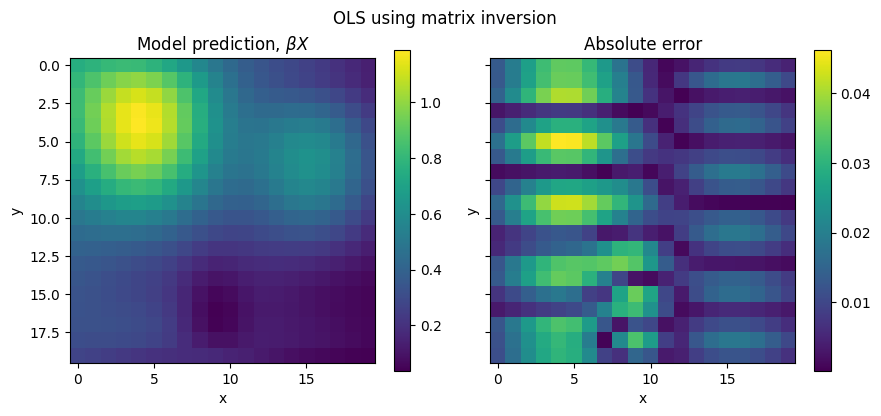

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(X @ beta)
im1 = ax[1].imshow(abs(data - X @ beta))

ax[0].set(title="Model prediction, " + r"$\beta X$", xlabel="x", ylabel="y")
ax[1].set(title=r"Absolute error", xlabel="x", ylabel="y")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()